In [1]:
from tectosaur2.nb_config import setup
setup()

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import panelize_symbolic_surface, gauss_rule, integrate_term
from tectosaur2.laplace2d import hypersingular

t = sp.var('t')
surf = panelize_symbolic_surface(t, 0 * t, t, gauss_rule(6), n_panels=80)
mat = hypersingular.direct(surf.pts, surf)[:, :, :, 0].reshape((-1, surf.n_pts))

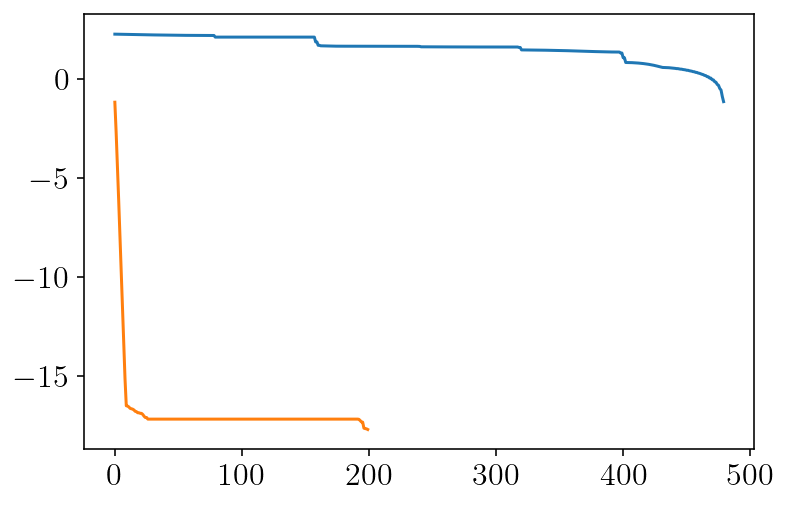

In [3]:
plt.plot(np.log10(np.linalg.svd(mat)[1]))
plt.plot(np.log10(np.linalg.svd(mat[-200:,:200])[1]))
plt.show()

In [4]:
U, S, V = np.linalg.svd(mat[-200:,:200])
np.argmax(S < 1e-10)

6

In [5]:
from dataclasses import dataclass
from typing import Optional


@dataclass()
class TreeNode:
    idx_start: int
    idx_end: int
    center: np.ndarray
    radius: float
    is_leaf: bool
    left: Optional["TreeNode"]
    right: Optional["TreeNode"]


@dataclass()
class Tree:
    ordered_idxs: np.ndarray
    root: TreeNode

In [6]:
def build_tree(pts, radii, min_pts_per_box=10):
    # The tree construction process receives three parameters:
    #
    # pts: the center of each element.
    #
    # radii: the radius of each element. Remember that we're dealing with spherical
    #        approximations to elements here instead of the triangular elements
    #        themselves.
    #
    # min_pts_per_box: this determines when we'll stop splitting. If a box has more
    #                  than min_pts_per_box elements, we keep splitting.

    # We'll start with the element indices in the order that they were given to this function.
    # build_tree_node will re-order these indices at each step to enforce the rule that
    # left child indices must be less than right child indices.
    ordered_idxs = np.arange(pts.shape[0])
    # The rest of the tree construction process will be handled by the recursive function:
    # build_tree_node. The last two parameters are idx_start and idx_end. For the root of the
    # tree, we pass the full set of elements: (0, pts.shape[0])
    root = build_tree_node(pts, radii, min_pts_per_box, ordered_idxs, 0, pts.shape[0])
    return Tree(ordered_idxs, root)

In [7]:
def build_tree_node(
    all_pts, all_radii, min_pts_per_box, ordered_idxs, idx_start, idx_end
):
    # 1) Collect the relevant element data.
    # A view into the ordered_idxs array for the elements we're working on here.
    idx_view = ordered_idxs[idx_start:idx_end]
    # And the center and radius of each element.
    pts = all_pts[idx_view]
    radii = all_radii[idx_view]

    # 2) Define the bounding box.
    box_center = np.mean(pts, axis=0)
    sep = pts - box_center[None, :]
    box_axis_length = np.max(sep, axis=0)
    box_radius = np.max(np.linalg.norm(sep, axis=1) + radii)

    # 3) Build the node
    # To start with, the left and right child are absent and is_leaf=True.
    # If the node is not a leaf, we'll overwrite these below.
    node = TreeNode(
        idx_start, idx_end, box_center, box_radius, is_leaf=True, left=None, right=None
    )

    # 4) Return if the node is a leaf node.
    # If there are fewer than min_pts_per_box elements in this node, then we do not split.
    if idx_end - idx_start <= min_pts_per_box:
        return node

    # 5) If the node is not a leaf, split!
    # First, find which axis of the box is longest
    split_d = np.argmax(box_axis_length)

    # Then identify which elements are on the left hand side of the box along that axis.
    split_val = np.median(pts[:, split_d])
    is_left = pts[:, split_d] < split_val

    # 6) Re-arrange indices.
    # Since we're going to re-arrange indices, we need to save the relevant indices first.
    left_idxs = idx_view[np.where(is_left)[0]].copy()
    right_idxs = idx_view[np.where(~is_left)[0]].copy()
    n_left = left_idxs.shape[0]
    # Then assign the left side indices to the beginning of our index block
    idx_view[:n_left] = left_idxs
    # And assign the right side indices to the end of our index block.
    idx_view[n_left:] = right_idxs

    # 7) Create children!
    idx_split = idx_start + n_left
    node.is_leaf = False

    # We recursively call build_tree_node here. The key difference between the left and right
    # sides is that the left receives the index block [idx_start, idx_split) and the right
    # receives the index block [idx_split, idx_end). Thus, we've created a smaller, equivalent
    # problem.
    node.left = build_tree_node(
        all_pts, all_radii, min_pts_per_box, ordered_idxs, idx_start, idx_split
    )
    node.right = build_tree_node(
        all_pts, all_radii, min_pts_per_box, ordered_idxs, idx_split, idx_end
    )

    return node

In [8]:
tree = build_tree(surf.pts, np.zeros(surf.n_pts), min_pts_per_box=30)
print("center =", tree.root.center)
print("radius =", tree.root.radius)

center = [ 0.00000000e+00 -2.31296463e-18]
radius = 0.9991558689275394


In [9]:
def check_tree(pts, radii, tree, node):
    if node is None:
        return True
    idxs = tree.ordered_idxs[node.idx_start : node.idx_end]
    dist = np.linalg.norm(pts[idxs] - node.center, axis=1) + radii[idxs]
    if np.any(dist > node.radius):
        return False
    else:
        return check_tree(pts, radii, tree, node.left) and check_tree(
            pts, radii, tree, node.right
        )


check_tree(surf.pts, np.zeros(surf.n_pts), tree, tree.root)

True

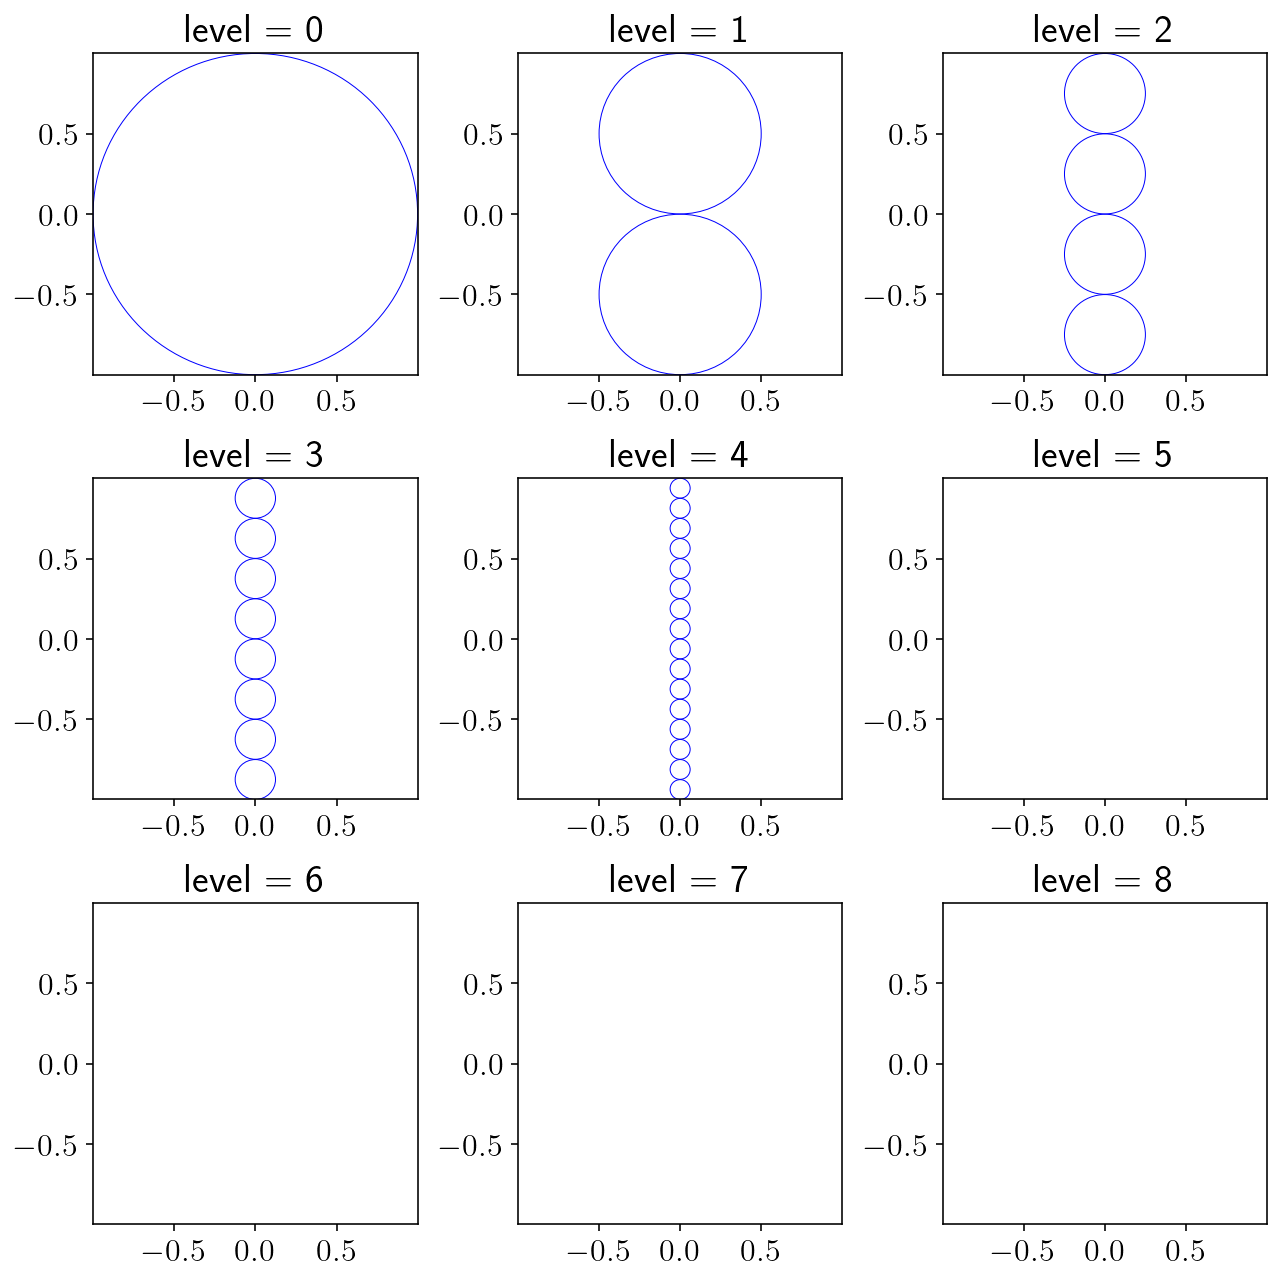

In [10]:
%matplotlib inline
def plot_tree(node, depth, **kwargs):
    if depth == 0:
        circle = plt.Circle(tuple(node.center[:2]), node.radius, fill=False, **kwargs)
        plt.gca().add_patch(circle)
    if node.left is None or depth == 0:
        return
    else:
        plot_tree(node.left, depth - 1, **kwargs)
        plot_tree(node.right, depth - 1, **kwargs)


plt.figure(figsize=(9, 9))
for depth in range(9):
    plt.subplot(3, 3, 1 + depth)
    plt.title(f"level = {depth}")
    plot_tree(tree.root, depth, color="b", linewidth=0.5)
    plt.xlim(
        [tree.root.center[0] - tree.root.radius, tree.root.center[0] + tree.root.radius]
    )
    plt.ylim(
        [tree.root.center[1] - tree.root.radius, tree.root.center[1] + tree.root.radius]
    )
plt.tight_layout()
plt.show()

In [11]:
def _traverse(obs_node, src_node, safety_factor, direct_list, approx_list):
    dist = np.linalg.norm(obs_node.center - src_node.center)
    if dist > safety_factor * (obs_node.radius + src_node.radius):
        # We're far away, use an approximate interaction
        approx_list.append((obs_node, src_node))
    elif obs_node.is_leaf and src_node.is_leaf:
        # If we get here, then we can't split the nodes anymore but they are
        # still close. That means we need to use a exact interaction.
        direct_list.append((obs_node, src_node))
    else:
        # We're close by, so we should recurse and use the child tree nodes.
        # But which node should we recurse with?
        split_src = (
            (obs_node.radius < src_node.radius) and not src_node.is_leaf
        ) or obs_node.is_leaf

        if split_src:
            _traverse(obs_node, src_node.left, safety_factor, direct_list, approx_list)
            _traverse(obs_node, src_node.right, safety_factor, direct_list, approx_list)
        else:
            _traverse(obs_node.left, src_node, safety_factor, direct_list, approx_list)
            _traverse(obs_node.right, src_node, safety_factor, direct_list, approx_list)


def traverse(obs_node, src_node, safety_factor=1.5):
    direct_list = []
    approx_list = []
    _traverse(obs_node, src_node, safety_factor, direct_list, approx_list)
    return direct_list, approx_list

In [12]:
direct, approx = traverse(tree.root, tree.root)

In [13]:
@dataclass()
class TempSurface:
    # ideally, these arrays are all views into other arrays without copying.
    pts: np.ndarray
    normals: np.ndarray
    quad_wts: np.ndarray
    jacobians: np.ndarray


tree_surf = TempSurface(
    surf.pts[tree.ordered_idxs],
    surf.normals[tree.ordered_idxs],
    surf.quad_wts[tree.ordered_idxs],
    surf.jacobians[tree.ordered_idxs],
)


def build_temp_surface(surf, s, e):
    return TempSurface(
        surf.pts[s:e],
        surf.normals[s:e],
        surf.quad_wts[s:e],
        surf.jacobians[s:e],
    )


def direct_block(obs_node, src_node):
    temp_src = build_temp_surface(tree_surf, src_node.idx_start, src_node.idx_end)
    obs_pts = surf.pts[obs_node.idx_start : obs_node.idx_end]
    M = hypersingular.direct(obs_pts, temp_src)
    return M.reshape((obs_pts.shape[0] * 2, src_node.idx_end - src_node.idx_start))

In [14]:
%%time
direct_blocks = [direct_block(d[0], d[1]) for d in direct]

CPU times: user 1.81 ms, sys: 848 µs, total: 2.65 ms
Wall time: 2.05 ms


In [15]:
from aca import ACA_plus, SVD_recompress
def approx_block_svd(obs_node, src_node):
    block = direct_block(obs_node, src_node)
    U, S, V = np.linalg.svd(block)
    # Reverse the list of singular values and sum them to compute the
    # error from each level of truncation.
    frob_K = np.sqrt(np.cumsum(S[::-1] ** 2))[::-1]

    appx_rank = np.argmax(frob_K < tol)

    Uappx = U[:, :appx_rank]
    Vappx = S[:appx_rank, None] * V[:appx_rank]
    return (Uappx, Vappx)

def approx_block(obs_node, src_node, tol):
    s = src_node.idx_start
    e = src_node.idx_end
    node_surf = TempSurface(
        tree_surf.pts[s:e], tree_surf.normals[s:e], tree_surf.quad_wts[s:e], tree_surf.jacobians[s:e]
    )
    node_obs_pts = surf.pts[tree.ordered_idxs][obs_node.idx_start:obs_node.idx_end]

    def calc_rows(Istart, Iend):
        obs_idx_start = Istart // 2
        obs_idx_end = (Iend - 1) // 2 + 1
        rows = hypersingular.direct(node_obs_pts[obs_idx_start:obs_idx_end], node_surf)
        # Reshape the returned array and filter out the extra rows.
        n_rows_computed = 2 * (obs_idx_end - obs_idx_start)
        rows2d = rows.reshape((n_rows_computed, -1))
        local_start = Istart % 2
        local_end = local_start + Iend - Istart
        filter_out_extra = rows2d[local_start:local_end, :]
        return filter_out_extra

    def calc_cols(s, e):
        temp_src = build_temp_surface(node_surf, s, e)
        return hypersingular.direct(node_obs_pts, temp_src)[:,:,:,0].reshape((-1, e - s))


    U_ACA, V_ACA = ACA_plus((obs_node.idx_end - obs_node.idx_start) * 2, e - s, calc_rows, calc_cols, tol, row_dim=2, col_dim=1)#, verbose=True)
    # return U_ACA, V_ACA
    U_SVD, V_SVD = SVD_recompress(U_ACA, V_ACA, 1e-10)
    return U_SVD, V_SVD

In [16]:
%%time
approx_blocks = [approx_block(d[0], d[1], 1e-10) for d in approx]

CPU times: user 33.9 ms, sys: 1.01 ms, total: 34.9 ms
Wall time: 34.4 ms


In [17]:
direct_block(*approx[0]).shape

(60, 60)

In [18]:
v = np.random.rand(mat.shape[1])


In [19]:
%%time
ytrue = mat.dot(v).reshape((-1, 2))


CPU times: user 519 µs, sys: 432 µs, total: 951 µs
Wall time: 176 µs


In [20]:
%%time
ytree = np.zeros(mat.shape[0])
treev = v[tree.ordered_idxs]

for i, (obs_node, src_node) in enumerate(direct):
    ytree[2*obs_node.idx_start:2*obs_node.idx_end] += direct_blocks[i].dot(treev[src_node.idx_start:src_node.idx_end])

for i, (obs_node, src_node) in enumerate(approx):
    v_subset = treev[src_node.idx_start:src_node.idx_end]
    U, V = approx_blocks[i] 
    ytree[2*obs_node.idx_start:2*obs_node.idx_end] += U.dot(V.dot(v_subset))

yh = np.zeros((mat.shape[0] // 2, 2))
yh[tree.ordered_idxs] = ytree.reshape((-1, 2))
yh[:5] - ytrue[:5]

CPU times: user 727 µs, sys: 495 µs, total: 1.22 ms
Wall time: 384 µs


array([[-2.89901436e-12, -1.72867409e-18],
       [-1.15107923e-12, -7.84764898e-23],
       [ 9.66338121e-13, -3.29502066e-25],
       [ 2.60769184e-12,  8.86326843e-30],
       [ 3.52429197e-12,  0.00000000e+00]])

In [21]:
approx_entries = sum([U.shape[0] * U.shape[1] + V.shape[0] * V.shape[1] for U, V in approx_blocks])
direct_entries = sum([M.shape[0] * M.shape[1] for M in direct_blocks])
(approx_entries + direct_entries) / mat.size

0.29108072916666666

In [22]:
for i, (obs_node, src_node) in enumerate(approx):
    U, V = approx_blocks[i]
    print(np.sqrt(
        np.sum((mat[2*obs_node.idx_start:2*obs_node.idx_end,src_node.idx_start:src_node.idx_end] - U.dot(V)) ** 2)
    ))

3.046949553618563e-11
2.780054414645761e-12
2.777546833210991e-12
3.0902210184522915e-11
7.09721879284364e-11
3.0469496782558664e-11
2.780051723990278e-12
1.6200253715323554e-11
7.097221184131416e-11
2.7985843991852583e-12
3.046949843656013e-11
1.696996306644212e-11
2.780056745191834e-12
3.3841064652494837e-11
2.782774139130503e-12
3.030742205706667e-11
3.62085122314316e-11
7.09721998775119e-11
2.7985887709463014e-12
3.3840833980211125e-11
1.6266695913924592e-11
8.346177374419736e-12
3.620847835418873e-11
7.097220440050202e-11
2.780053000439712e-12
3.055289091155933e-11
1.7063486052077113e-11
8.523647184968686e-12
2.7800473047871213e-12
3.384133252058764e-11
2.7800468616500326e-12
3.046950000754669e-11
7.09722112249426e-11
2.781272605439737e-12
3.3840887924286606e-11
1.6200272874237956e-11
7.097220304594139e-11
2.7985854232536354e-12
3.0469494837161824e-11
1.6872139950272907e-11
3.030743141716141e-11
2.780054808316695e-12
3.384122434617336e-11
2.7812685650913714e-12


In [46]:
os.getcwd()

'/Users/tbent/Dropbox/active/eq/tectosaur2/experiments'

In [65]:
import cutde.backend

In [68]:
for k, v in cutde.backend.__dict__.items():
    if not k.startswith('__'):
        print(k, v)

logging <module 'logging' from '/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/logging/__init__.py'>
os <module 'os' from '/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/os.py'>
np <module 'numpy' from '/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/numpy/__init__.py'>
empty <function empty at 0x12f8f78b0>
get <function get at 0x12f8f7700>
load_module <function load_module at 0x12f8f7c10>
max_block_size <function max_block_size at 0x12f8f7790>
to <function to at 0x12f8f74c0>
zeros <function zeros at 0x12f8f7670>
which_backend cpp
logger <Logger cutde.backend (WARNING)>
np_to_c_type <function np_to_c_type at 0x12f8f7a60>
intervals <function intervals at 0x12f8f7dc0>


In [62]:
from tectosaur2.nb_config import cython

cython('-f -I../tectosaur2', file='../tectosaur2/hmatrix_ext.pyx')

In file included from /Users/tbent/.ipython/cython/_cython_magic_914fa22feb7abd9b724989f142cad0cc.c:698:
../tectosaur2/hmatrix.cpp:7:1: error: unknown type name 'WITHIN_KERNEL'
WITHIN_KERNEL 
^
../tectosaur2/hmatrix.cpp:8:18: error: unknown type name 'GLOBAL_MEM'
int buffer_alloc(GLOBAL_MEM int* next_ptr, int n_values) {
                 ^
../tectosaur2/hmatrix.cpp:10:5: error: expected expression
    % if backend == 'cuda':
    ^
../tectosaur2/hmatrix.cpp:10:7: error: expected expression
    % if backend == 'cuda':
      ^
../tectosaur2/hmatrix.cpp:12:5: error: expected expression
    % elif backend == 'opencl':
    ^
../tectosaur2/hmatrix.cpp:12:7: error: use of undeclared identifier 'elif'
    % elif backend == 'opencl':
      ^
../tectosaur2/hmatrix.cpp:14:5: error: expected expression
    % else:
    ^
../tectosaur2/hmatrix.cpp:14:7: error: expected expression
    % else:
      ^
../tectosaur2/hmatrix.cpp:24:1: error: unknown type name 'WITHIN_KERNEL'
WITHIN_KERNEL
^
../tectosaur2

In [39]:
%%cython
cdef extern from '../tectosaur2/hmatrix.cpp':
    double square(double x)

def f(double x):
    return 3*square(x)

/Users/tbent/.ipython/cython/_cython_magic_49722f780fe91d9c3e4809d03b525cf0.c:695:10: fatal error: '../tectosaur2/hmatrix.cpp' file not found
#include "../tectosaur2/hmatrix.cpp"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~
1 error generated.


In [61]:
f(2)

37.69911184307752